In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

2024-11-10 10:33:53.064521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 10:33:53.079985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731231233.088611 1223301 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731231233.091125 1223301 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 10:33:53.100120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def periodic_trans(time):
    time_period = np.round([np.cos(time[:,0]/12*2*np.pi),
                            np.sin(time[:,0]/12*2*np.pi),
                            np.cos(time[:,1]/60*2*np.pi),
                            np.sin(time[:,1]/60*2*np.pi)],5)
    return time_period.T

def period_to_hrmin(period_time,hr_or_min):
    # convert period to clk time (either hr or min, for hr use 12, for min use 60 for hr_or_min)
    time_y_rad = np.arctan2(period_time[:,1],period_time[:,0])
    time_y = (time_y_rad < 0)*2*np.pi + time_y_rad
    time_clk = time_y/2/np.pi*hr_or_min
    return np.round(time_clk)

def period_to_clk(period_time):
    return np.array([period_to_hrmin(period_time[:,:2],12),
                     period_to_hrmin(period_time[:,2:],60)]).T

# ty1 = period_to_clk(train_ty_period)
# test_ty_period = periodic_trans(test_ty)

def calculate_angle(vec1, vec2):
    dot_product = np.sum(vec1 * vec2, axis=1)
    mag1 = np.linalg.norm(vec1, axis=1)
    mag2 = np.linalg.norm(vec2, axis=1)
    cos_theta = dot_product / (mag1 * mag2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid domain errors
    return angle

def common_sense_err(test_y,pred_y):
    hr_angle = calculate_angle(test_y[:,:2],pred_y[:,:2])
    min_angle = calculate_angle(test_y[:,2:],pred_y[:,2:])
    hr_diff = hr_angle/2/np.pi*12
    min_diff = min_angle/2/np.pi*60
    return np.round(np.array([hr_diff,min_diff]).T)

def single_angle_trans(clk_time):
    time_rad = clk_time[:,0]/12*2*np.pi + clk_time[:,1]/60*np.pi/6
    time_per = np.array(np.round([np.cos(time_rad),
                                  np.sin(time_rad)],5)).T
    return time_per

def s_ang_to_clk(s_angle):
    y_rad = np.arctan2(s_angle[:,1],s_angle[:,0])
    y_rad2 = (y_rad < 0)*2*np.pi + y_rad
    y_clk = y_rad2/2/np.pi*12
    return np.array([y_clk.astype(int),np.round(y_clk%1*60)]).T

def common_sense_err2(test_y,pred_y):
    sa1 = single_angle_trans(pred_y)
    sa2 = single_angle_trans(test_y)
    sa_diff = calculate_angle(sa1,sa2)
    hr_diff = sa_diff//(np.pi/6)
    min_diff = np.round((sa_diff%(np.pi/6)*6*60/np.pi))
    return np.array([hr_diff,min_diff]).T


In [3]:
time_x = np.load('s_images.npy')
time_y = np.load('s_labels.npy')
train_tx, test_tx, train_ty, test_ty = train_test_split(time_x, time_y, test_size=0.1, random_state=42)
train_ty[:10],test_ty[:10]
train_ty_period = periodic_trans(train_ty)
test_ty_period = periodic_trans(test_ty)
train_ty_period[:,2:]


array([[-0.97815,  0.20791],
       [-0.91355, -0.40674],
       [ 0.97815, -0.20791],
       ...,
       [-0.86603, -0.5    ],
       [-0.91355, -0.40674],
       [-0.99452, -0.10453]])

In [4]:
# print(len(np.unique(train_ty,axis=0)))
from keras.utils import to_categorical 
# print(test_ty11[:,1])
n = 30
def class_class(n,test_ty):
    test_ty11 = test_ty.copy()
    test_ty11[:,1] = test_ty11[:,1]//n*n
    # print(len(np.unique(test_ty11,axis=0)))
    cs1 = common_sense_err2(test_ty,test_ty11)
    print(np.mean(cs1,axis=0))
    df2 = (test_ty11[:,0]+test_ty11[:,1]/60)*(60/n)
    # print(len(np.unique(df2)))
    return to_categorical(df2,)
# test_ty[1:10]
class24_tr = class_class(30,train_ty)
class24_te = class_class(30,test_ty)
print(test_ty[1:3])
print(class24_te[1:3])
print(np.argmax(class24_te[1:3],axis=1))

def convert_ori(df1,n1):
    n = 60//n1
    hr1 = df1//n
    min1 = df1%n*n1
    or1 = np.array([hr1,min1]).T
    return or1
convert_ori(np.argmax(class24_te[1:3],axis=1),30)

[ 0.         14.48987654]
[ 0.         14.59111111]
[[ 4 59]
 [ 6  8]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[ 9 12]


array([[ 4, 30],
       [ 6,  0]])

[ 0.         14.48987654]
[ 0.         14.59111111]


I0000 00:00:1731231370.407483 1223301 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1183 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,920 (1.79 MB)

 Trainable params: 468,472 (1.79 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50


I0000 00:00:1731231371.722418 1227341 service.cc:148] XLA service 0x7fa668012520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731231371.722434 1227341 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-10 10:36:11.750148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731231371.865367 1227341 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-10 10:36:11.963307: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 18/456 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0416 - loss: 6.7218

I0000 00:00:1731231374.188001 1227341 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.0404 - loss: 6.2526 - val_accuracy: 0.0377 - val_loss: 5.2539 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0533 - loss: 4.9846 - val_accuracy: 0.0580 - val_loss: 4.3358 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0705 - loss: 4.1818 - val_accuracy: 0.0821 - val_loss: 3.7686 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1019 - loss: 3.6564 - val_accuracy: 0.1278 - val_loss: 3.3349 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1350 - loss: 3.2797 - val_accuracy: 0.1722 - val_loss: 2.9718 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1733 - loss: 2.9869 - val_accuracy: 0.2216 - val_loss: 2.6908 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2082 - 

array([ 0.07333333, 15.87666667])

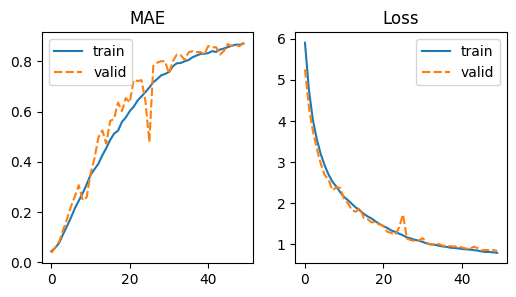

In [5]:
K.clear_session()
n = 30
class24_tr = class_class(n,train_ty)
class24_te = class_class(n,test_ty)
num_class = 60//n*12

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(num_class,activation='softmax')(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= "categorical_crossentropy",
                       metrics=['accuracy'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx, class24_tr,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['accuracy']
mae_df['valid'] = his_model_time_P1_L.history['val_accuracy']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx,  class24_te, verbose=2)
pred_y_P1_L = np.argmax(model_time_P1_L.predict(test_tx),axis=1)
pred_P1_L = convert_ori(pred_y_P1_L,n)
np.mean(common_sense_err2(test_ty,pred_P1_L),axis = 0)

[0. 0.]
[0. 0.]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 720)            │        46,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,160 (1.96 MB)

 Trainable params: 513,712 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50


2024-11-10 10:39:30.617430: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1953', 316 bytes spill stores, 316 bytes spill loads

2024-11-10 10:39:30.619083: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1953', 88 bytes spill stores, 88 bytes spill loads



451/456 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0016 - loss: 9.3994

2024-11-10 10:39:36.047074: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1953', 88 bytes spill stores, 88 bytes spill loads

2024-11-10 10:39:36.061909: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1953', 128 bytes spill stores, 128 bytes spill loads



456/456 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.0016 - loss: 9.3940 - val_accuracy: 0.0031 - val_loss: 8.0213 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0029 - loss: 7.7455 - val_accuracy: 0.0025 - val_loss: 7.1607 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0017 - loss: 7.0510 - val_accuracy: 0.0012 - val_loss: 6.8411 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0017 - loss: 6.7893 - val_accuracy: 0.0031 - val_loss: 6.7159 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0038 - loss: 6.6748 - val_accuracy: 0.0025 - val_loss: 6.6623 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0032 - loss: 6.6238 - val_accuracy: 0.0012 - val_loss: 6.6456 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0042 - l

array([ 1.03111111, 17.46333333])

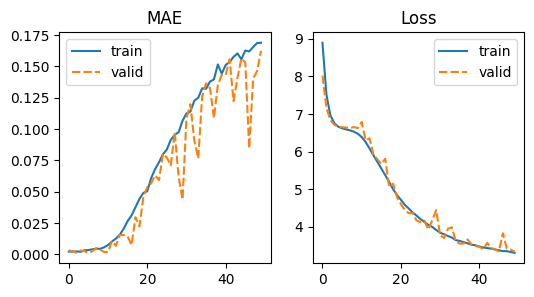

In [6]:
K.clear_session()
n = 1
class24_tr = class_class(n,train_ty)
class24_te = class_class(n,test_ty)
num_class = 60//n*12

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(num_class,activation='softmax')(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= "categorical_crossentropy",
                       metrics=['accuracy'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx, class24_tr,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['accuracy']
mae_df['valid'] = his_model_time_P1_L.history['val_accuracy']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx,  class24_te, verbose=2)
pred_y_P1_L = np.argmax(model_time_P1_L.predict(test_tx),axis=1)
pred_P1_L = convert_ori(pred_y_P1_L,n)
np.mean(common_sense_err2(test_ty,pred_P1_L),axis = 0)

In [9]:
np.mean(pred_P1_L[:,0] == test_ty[:,0])

np.float64(0.5516666666666666)